In [3]:
"""
This script explores a single dataset and produces results only for it
"""

'\nThis script explores a single dataset and produces results only for it\n'

In [4]:
"""
NOTE: to run notebook use: venv/bin/python manage.py shell_plus --notebook
"""

MYPROJECT='/Users/erotundo/PycharmProjects/DatasetAnnotatorProj'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")

import django
django.setup()

from django.conf import settings
from DatasetAnnotator.models import Posts
from django.db.models import Q, F
from django.db.models import Count, Sum, Max, Avg
from django.db.models import When, Case, Value
from django.db.models import IntegerField, FloatField
import numpy as np
import pandas as pd
from django.db.models.functions import Greatest, Coalesce

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# community selection
#available_dbs = settings.DATABASES.keys()[1:]
db = 'travel'


# plotting settings
sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = 'AnalysisBestAnswer/plots/' + db + '/'
PLOTS_FORMATS = ['.pdf', '.png']

# Nr answers and nr questions, per user (all data)

In [5]:
# note: ids are non-negative integers
users_activity = {
    'whole_data': {
        db: {
            # '1': {
            #     'nr_questions': -1,
            #     'nr_answers': -1
            # }   
        },
    }
}





    
# whole_data

# ex. [{'owneruserid': 17L, 'nr_questions': 13, 'nr_answers': 12}, {...}, {...}]
whole_d_vals = Posts.objects.using(db)\
    .order_by()\
    .values('owneruserid')\
    .distinct()\
    .annotate(
        nr_questions=Sum(
        Case(When(posttypeid=1, then=Value(1)),
             default=Value(0),
             output_field=IntegerField())),
        nr_answers=Sum(
        Case(When(posttypeid=2, then=Value(1)),
             default=Value(0),
             output_field=IntegerField()))
    )

data = dict()
for val in whole_d_vals:
    # owneruserid == None if user has been deleted, -1 for wiki entries, see http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
    if val['owneruserid'] >= 1:
        data[val['owneruserid']] = {'nr_questions': val['nr_questions'], 'nr_answers': val['nr_answers']}
users_activity['whole_data'][db] = data



    
# extract: each data point is a user, x is #questions, y is #answers

# whole data
whole_d = pd.DataFrame.from_dict(users_activity['whole_data'][db], orient='index')

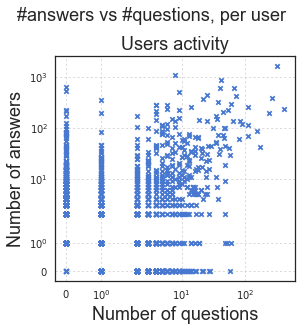

In [9]:
s=20

# scatter plots

fig = plt.figure(figsize=(5, 5))
fig.suptitle("#answers vs #questions, per user", fontsize=18)

ax1 = fig.add_subplot(111)
ax1.set_xscale('symlog', nonposx='clip')
ax1.set_yscale('symlog', nonposx='clip')
ax1.scatter(x=whole_d['nr_questions'], 
            y=whole_d['nr_answers'], 
            label='cooking', s=s, c='b', marker='x')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title('Users activity', fontsize=18)
plt.grid(alpha=0.7, linestyle='dotted')


plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_scatter_ALL' + plot_format)

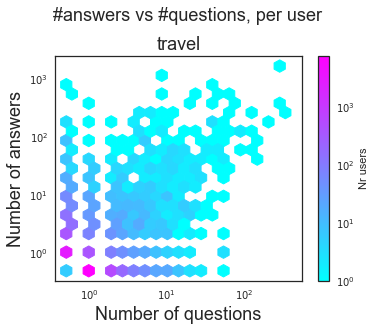

In [12]:
# hex bins

gridsize = 20

fig = plt.figure(figsize=(6, 5))
fig.suptitle("#answers vs #questions, per user", fontsize=18)

ax1 = fig.add_subplot(111, sharey=ax1, sharex=ax1)
hb = ax1.hexbin(x=whole_d['nr_questions'].replace(0, 0.5), 
                y=whole_d['nr_answers'].replace(0, 0.5), 
                xscale='log', 
                yscale='log',
                norm=matplotlib.colors.LogNorm(),
                label=db,
                cmap='cool',
                gridsize=gridsize,
                mincnt=1)
#ax1.axis([0.5, whole_d_cooking['nr_questions'].max(), 0.5, whole_d_cooking['nr_answers'].max()])
cb = fig.colorbar(hb, ax=ax1)
cb.set_label('Nr users')
plt.xlabel('Number of questions', fontsize=18)
plt.ylabel('Number of answers', fontsize=18)
plt.title(db, fontsize=18)




plt.tight_layout(pad=3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'nr_answers_VS_nr_questions_2dhist_ALL' + plot_format)